# ***`Amazon Fine Food Reviews`***

---

1. [ABC](#ABC)
2. [ABC2](#ABC2)

## ***`Import Packages`***

In [1]:
import os
import sys
import logging

logging.basicConfig(filename="SA2_Fine_Food_reviews.log",
                    filemode='w',
                    level=logging.INFO,
                    format="%(asctime)s : %(levelname)s : %(message)s")

try :
    logging.info("#### Packages import ####")
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import sklearn
    import scipy
    import nltk
    import sqlite3 as sq3    
except ImportError as ie:
    # Output expected ImportErrors
    logging.error(msg=ie.__class__.__name__  + " :: Missing Package --> " + ie.name)
except Exception as exception:
    # Output unexpected Exceptions
    logging.info("#### Exceptions other than ModuleImportError ####")
    logging.log(msg=(exception, False))
    logging.log(msg=exception.__class__.__name__ + " :: " + exception.name)

%matplotlib inline

##### **Setting global variables**

In [2]:
title_font_dict = {'size':21,'family':'calibri','style':'oblique','color':'purple'}
labels_font_dict = {'size':19,'family':'calibri','style':'oblique','color':'coral'}

##### **Setting the max rows display number**

In [3]:
pd.set_option('display.max_rows',50)

##### **Creating SQLite connection**

In [4]:
sq3_conn = sq3.connect('Datasets/database.sqlite')

In [5]:
tables_list = '''SELECT 
    name as TABLES
FROM 
    sqlite_master 
WHERE 
    type ='table'AND 
    name NOT LIKE 'sqlite_%';'''

In [6]:
pd.read_sql_query(sql=tables_list,con=sq3_conn)

,TABLES
0,Reviews


#### **Some additional description**

In [7]:
pd.read_sql_query('''SELECT * FROM sqlite_master''',con=sq3_conn)

,type,name,tbl_name,rootpage,sql
0,table,Reviews,Reviews,2,CREATE TABLE Reviews (\n Id INTEGER PRIMARY...


### **We only have 1 table in this database i.e. `Reviews`**

#### **Now, lets explore the Reviews table...**

In [8]:
reviews_df = pd.read_sql_query('''SELECT * FROM reviews WHERE score != 3;''',con=sq3_conn)

In [9]:
reviews_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [10]:
reviews_df.shape

(525814, 10)

In [11]:
reviews_df['Score'].value_counts()

5    363122
4     80655
1     52268
2     29769
Name: Score, dtype: int64

In [12]:
reviews_df['Label'] = reviews_df['Score'].apply(lambda scr: 'Positive' if scr > 3 else 'Negative')

In [13]:
reviews_df['Label'].value_counts()

Positive    443777
Negative     82037
Name: Label, dtype: int64

In [14]:
reviews_df.drop(labels=['Id','Score'],axis=1,inplace=True)
reviews_df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Label
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive


## ***`Exploratory_Data_Analysis`***

#### **Q1. What are the top 50 most reviewed products?**

In [15]:
most_rvw_prd = pd.DataFrame(reviews_df['ProductId'].value_counts()).reset_index().head(50)
most_rvw_prd.head()

,index,ProductId
0,B007JFMH8M,857
1,B002QWP8H0,611
2,B002QWP89S,611
3,B0026RQTGE,611
4,B002QWHJOU,611


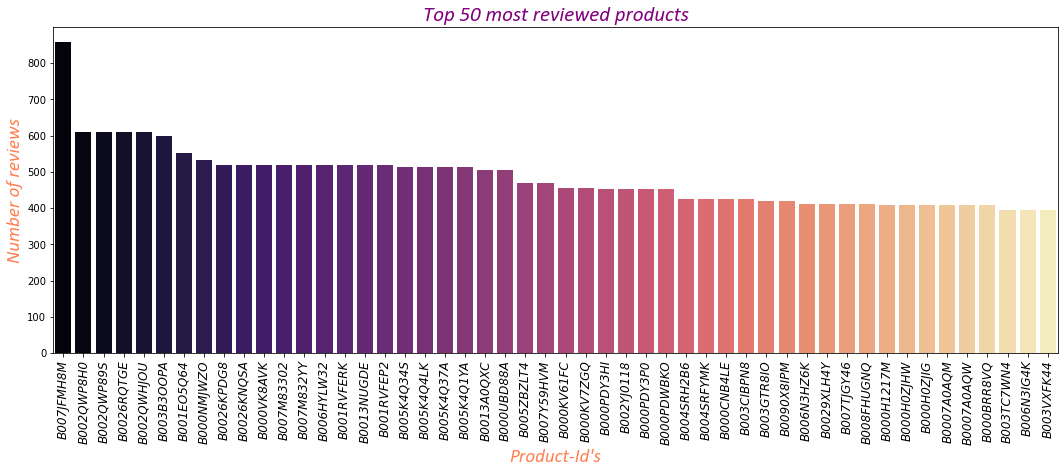

In [16]:
with plt.style.context('seaborn-bright'):
    plt.figure(figsize=(18,6))
    sns.barplot(data=most_rvw_prd,x='index',y='ProductId',palette='magma')
    plt.title("Top 50 most reviewed products",fontdict=title_font_dict)
    plt.xlabel("Product-Id's",fontdict=labels_font_dict)
    plt.ylabel("Number of reviews",fontdict=labels_font_dict)
    plt.xticks(rotation=90,size=12,style='oblique')

#### **Q2. Does one user review is getting duplicated for multiple Products?**

In [17]:
dup_reviews = pd.DataFrame(reviews_df.groupby(['UserId','ProfileName','Time','Summary','Text'])['ProductId'].count())

In [18]:
dup_reviews = dup_reviews[dup_reviews['ProductId'] > 1].reset_index().sort_values(by='ProductId',ascending=False).reset_index()
dup_reviews.drop(['index'],axis=1,inplace=True)
dup_reviews.head(10)

,UserId,ProfileName,Time,Summary,Text,ProductId
0,A3TVZM3ZIXG8YW,christopher hayes,1291420800,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",199
1,A29JUMRL1US6YP,HTBK,1278201600,Fantastic Food for Good Cat Health,The pet food industry can be one of the most i...,45
2,A1UQBFCERIP7VJ,Margaret Picky,1321401600,Stash Chamomile Herbal Tea,Stash Chamomile Herbal Tea is tea bags with dr...,36
3,A29JUMRL1US6YP,HTBK,1278201600,Fantastic Food for Good Cat Health,The pet food industry can be one of the most i...,35
4,A36JDIN9RAAIEC,Jon,1292976000,"Great product, but trust your vet not the hype","I have two cats, one 6 and one 2 years old. Bo...",34
5,A20P8VC55KPPCT,FL Mom,1310860800,Love all HappyBaby Tots!,My kids (18 mo and 3 yrs) love the HappyBaby T...,31
6,AYQ8RLE0K6RU8,"M. Brown ""TankerToys.com""",1187913600,3 out of 4 Paws,"First Impression: The friendly folks over at ""...",31
7,A24PZR4W555WQI,D. Saldarriaga,1294617600,My dogs love Wellness,My dogs and I love this food. They never leave...,28
8,A3PJZ8TU8FDQ1K,Jared Castle,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh...",28
9,A1BD342U8BF3UC,Britney,1314230400,I got this for a diet i tried,"Ok, sounds crazy i know but i heard about this...",28


### **Here are some unexpected results, many reviews are getting duplicated across products. And, one of the user reviews is getting duplicated for almost 200 times across different products.**

#### **`Example-1`**

In [19]:
reviews_df[(reviews_df['UserId'] == 'A29JUMRL1US6YP') & (reviews_df['Time'] == 1278201600)]

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Label
58313,B0019ZB4KA,A29JUMRL1US6YP,HTBK,6,6,1278201600,Fantastic Food for Good Cat Health,The pet food industry can be one of the most i...,Positive
106360,B000WFUL3E,A29JUMRL1US6YP,HTBK,3,4,1278201600,Fantastic Food for Good Cat Health,The pet food industry can be one of the most i...,Positive
106396,B000WFUL3E,A29JUMRL1US6YP,HTBK,38,40,1278201600,Fantastic Food for Good Cat Health,The pet food industry can be one of the most i...,Positive
106402,B000WFUL3E,A29JUMRL1US6YP,HTBK,19,23,1278201600,Fantastic Food for Good Cat Health,The pet food industry can be one of the most i...,Positive
106405,B000WFUL3E,A29JUMRL1US6YP,HTBK,12,14,1278201600,Fantastic Food for Good Cat Health,The pet food industry can be one of the most i...,Positive
...,...,...,...,...,...,...,...,...,...
449582,B00008CQVA,A29JUMRL1US6YP,HTBK,3,3,1278201600,Fantastic Food for Good Cat Health,The pet food industry can be one of the most i...,Positive
449583,B00008CQVA,A29JUMRL1US6YP,HTBK,3,3,1278201600,Fantastic Food for Good Cat Health,The pet food industry can be one of the most i...,Positive
449590,B00008CQVA,A29JUMRL1US6YP,HTBK,5,6,1278201600,Fantastic Food for Good Cat Health,The pet food industry can be one of the most i...,Positive
449613,B00008CQVA,A29JUMRL1US6YP,HTBK,2,2,1278201600,Fantastic Food for Good Cat Health,The pet food industry can be one of the most i...,Positive


In [20]:
reviews_df[(reviews_df['UserId'] == 'A29JUMRL1US6YP') & (reviews_df['Time'] == 1278201600)]['ProductId'].unique()

array(['B0019ZB4KA', 'B000WFUL3E', 'B000WFKWDI', 'B000WFORH0',
       'B000WFN0VO', 'B000WFU8O6', 'B000WFKI82', 'B000WFEN74',
       'B000WFRQQ4', 'B000084EZ4', 'B000WFPJIG', 'B002ANCEI6',
       'B00008CQVA'], dtype=object)

#### **`Example-2`**

In [21]:
reviews_df[(reviews_df['UserId'] == 'A1UQBFCERIP7VJ') & (reviews_df['Time'] == 1321401600)]

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Label
25265,B006H32PWU,A1UQBFCERIP7VJ,Margaret Picky,0,0,1321401600,Stash Chamomile Tea,Stash Chamomile Herbal Tea is tea bags with dr...,Positive
28757,B004JZKQ8S,A1UQBFCERIP7VJ,Margaret Picky,0,0,1321401600,"A ginormous box of 1,000 tea bags",Stash Chamomile Herbal Tea is tea bags with dr...,Positive
36690,B0029EZUHS,A1UQBFCERIP7VJ,Margaret Picky,0,0,1321401600,Stash Chamomile Herbal Tea,Stash Chamomile Herbal Tea is tea bags with dr...,Positive
75584,B005ZHC7EA,A1UQBFCERIP7VJ,Margaret Picky,0,0,1321401600,Stash Chamomile Herbal Tea,Stash Chamomile Herbal Tea is tea bags with dr...,Positive
80752,B004JLHU6S,A1UQBFCERIP7VJ,Margaret Picky,0,0,1321401600,"A ginormous box of 1,000 tea bags",Stash Chamomile Herbal Tea is tea bags with dr...,Positive
...,...,...,...,...,...,...,...,...,...
468850,B000CQIDHO,A1UQBFCERIP7VJ,Margaret Picky,0,0,1321401600,Stash Chamomile Herbal Tea,Stash Chamomile Herbal Tea is tea bags with dr...,Positive
471224,B003D4GSL0,A1UQBFCERIP7VJ,Margaret Picky,0,0,1321401600,Stash Chamomile Herbal Tea,Stash Chamomile Herbal Tea is tea bags with dr...,Positive
511424,B002HFQUX2,A1UQBFCERIP7VJ,Margaret Picky,0,0,1321401600,Stash Chamomile Herbal Tea,Stash Chamomile Herbal Tea is tea bags with dr...,Positive
520210,B000WS0GPO,A1UQBFCERIP7VJ,Margaret Picky,0,0,1321401600,Stash Chamomile Herbal Tea,Stash Chamomile Herbal Tea is tea bags with dr...,Positive


In [22]:
pd.set_option('display.max_colwidth',2000)

##### **Product-1**

In [23]:
reviews_df[(reviews_df['UserId'] == 'A1UQBFCERIP7VJ') & 
    (reviews_df['Time'] == 1321401600) & 
    (reviews_df['ProductId'] =='B006H32PWU')][['Summary','Text']]

,Summary,Text
25265,Stash Chamomile Tea,"Stash Chamomile Herbal Tea is tea bags with dried, crushed chamomile flowers.<br /><br />Honestly, as far as I'm concerned, chamomile is chamomile. I suppose that when you use loose flowers you get sediment in the cup and I have seen this happen with some brands of chamomile tea bags, these don't do that.<br /><br />I have also had organic chamomile (this isn't) but I can't taste the difference.<br /><br />Each bag is individually packaged and that is either good or bad depending on how and where you use it and if you are concerned about excessive packaging.<br /><br />If you like chamomile tea, this is a good choice."


##### **Product-2**

In [24]:
reviews_df[(reviews_df['UserId'] == 'A1UQBFCERIP7VJ') & 
    (reviews_df['Time'] == 1321401600) & 
    (reviews_df['ProductId'] =='B004JZKQ8S')][['Summary','Text']]

,Summary,Text
28757,"A ginormous box of 1,000 tea bags","Stash Chamomile Herbal Tea is tea bags with dried, crushed chamomile flowers.<br /><br />Honestly, as far as I'm concerned, chamomile is chamomile. I suppose that when you use loose flowers you get sediment in the cup and I have seen this happen with some brands of chamomile tea bags, these don't do that.<br /><br />I have also had organic chamomile (this isn't) but I can't taste the difference.<br /><br />Each bag is individually packaged and that is either good or bad depending on how and where you use it and if you are concerned about excessive packaging.<br /><br />If you really, truly like chamomile tea, or own a restaurant, this ginormous box of 1,000 single-serving tea bags is a good choice."


### **Now, both the above products belongs to the `Stash Tea`. However, product-1 is the pack of 10 tea bags and product-2 is the pack of 1000 tea bags.**

### **One strange thing here is that the same user provided the reviews of both the products at the same time with a very slight change in the text. Although, such comments are different but they are not providing any differnt information.**

In [25]:
reviews_df.drop_duplicates(subset={'UserId','ProfileName','Time','Summary','Text'},keep='first',inplace=True)

In [26]:
reviews_df.shape

(365333, 9)

#### **Q3. How many duplicate reviews from a user?**

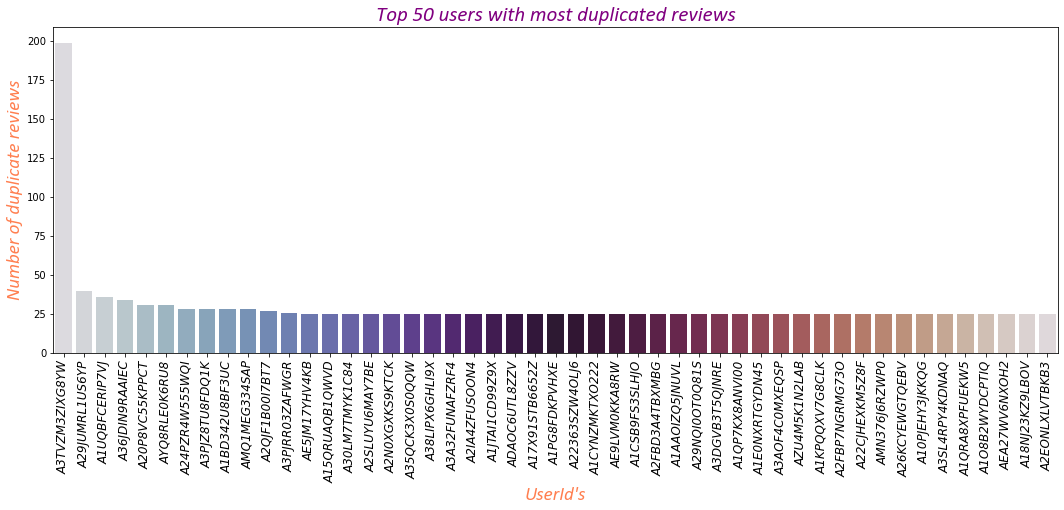

In [27]:
with plt.style.context('seaborn-bright'):
    plt.figure(figsize=(18,6))
    sns.barplot(data=dup_reviews.iloc[0:50,:],x='UserId',y='ProductId',palette='twilight',ci=False)
    plt.title("Top 50 users with most duplicated reviews",fontdict=title_font_dict)
    plt.xlabel("UserId's",fontdict=labels_font_dict)
    plt.ylabel("Number of duplicate reviews",fontdict=labels_font_dict)
    plt.xticks(rotation=90,size=12,style='oblique')

#### **Q4. Can HelpfulnessDenominator be smaller than HelpfulnessNumerator?**

In [28]:
pd.set_option('display.max_colwidth',50)

In [29]:
reviews_df[reviews_df['HelpfulnessDenominator'] < reviews_df['HelpfulnessNumerator']]

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Label
41159,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...,Positive
59301,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...,Positive


### **Here, the answer is No, as the HelpfulnessDenominator cannot be smaller than HelpfulnessNumerator.**

In [30]:
reviews_df = reviews_df[reviews_df['HelpfulnessDenominator'] >= reviews_df['HelpfulnessNumerator']]
reviews_df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Label
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive


In [31]:
reviews_df.shape

(365331, 9)

## ***`Text_Processing`***

In [35]:
from nltk.corpus import stopwords

In [43]:
eng_stop_words = stopwords.words('english')

##### **English Stopwords**

In [45]:
print(eng_stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### **Removing "no,nor,not" from the stopwords list as they represent negative sentiments**

In [70]:
eng_stop_words.remove('no')
eng_stop_words.remove('nor')
eng_stop_words.remove('not')

In [72]:
print(eng_stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', '

##### **Checking some random text messages**

In [47]:
pd.set_option('display.max_colwidth',2000)

In [100]:
random_values = np.random.randint(low=0,high=reviews_df.shape[0],size=20)
for val in random_values:
    print(val,reviews_df['Text'].iloc[val])
    print("=="*50,"\n")

298040 My daughter loves this one, and I have to admit it's pretty tasty. It's thick enough that I can put globs of it on her tray for her to feed herself without making a huge mess. If she opts to use a spoon, it's also more likely than other varieties to make it to her mouth before falling into her lap.

50975 5-hour energy drink works within minutes.  It gives me that extra boost I sometimes need to get started in the morning and it lasts a long time.5 Hour Energy, Berry Flavor, 2 Oz, Box/12

123781 I really love this product. It is creamy smooth, and rich. Helps that undereye area stay firm.  It does reduce the puffyness.  The coffee aroma is not unpleasant.

193464 My 10 month old daughter is eating chunky foods such as this and table foods that are appropriate for her. This Gerber lasagna with meat sauce states that it is appropriate for crawlers (babies usually crawl way before hitting the one year mark).  Yet in the ingredients states that it contains egg whites, which are not 

### **Here, we found out that the reviews contains XML tags, special characters and https links as well.**

In [101]:
reviews_df['Text'].iloc[186603]

"Seller ships quickly & great bargain compared to supermarket prices & grinding the raw seeds yourself. There are recipes online for a Focaccia flat bread & we just made some muffins with walnuts & almonds that turned out pretty good. The bread is dark like a bran & consistency of banana bread & was thinking of experimenting & mixing with almond flour or regular flour to see how it turns out. Don't expect it to be like your supermarket loaf of bread but at 0 net carbs, you can have a great alternative to sandwiches, snacks & fiber. Check out the links & enjoy:<br />[...]<br />[...]<br />[...]"

In [113]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

soup = BeautifulSoup(reviews_df['Text'].iloc[186603], 'lxml')
## Removing all the XML tags
text1 = soup.get_text()
## Removing all the short forms defined in above function
text2 = decontracted(text1)
## Removing all the number with words
text3 = re.sub("\S*\d\S*", "",text2)
## Removing all the special characters and spaces from the resultant text
text4 = re.sub('[^A-Za-z0-9]+', ' ',text3).strip()
# text = re.sub("\S*\d\S*", "",re.sub('[^A-Za-z0-9]+', ' ',decontracted(soup.get_text()))).strip()
print(text1)
print(text2)
print(text3)
print(text4)

Seller ships quickly & great bargain compared to supermarket prices & grinding the raw seeds yourself. There are recipes online for a Focaccia flat bread & we just made some muffins with walnuts & almonds that turned out pretty good. The bread is dark like a bran & consistency of banana bread & was thinking of experimenting & mixing with almond flour or regular flour to see how it turns out. Don't expect it to be like your supermarket loaf of bread but at 0 net carbs, you can have a great alternative to sandwiches, snacks & fiber. Check out the links & enjoy:[...][...][...]
Seller ships quickly & great bargain compared to supermarket prices & grinding the raw seeds yourself. There are recipes online for a Focaccia flat bread & we just made some muffins with walnuts & almonds that turned out pretty good. The bread is dark like a bran & consistency of banana bread & was thinking of experimenting & mixing with almond flour or regular flour to see how it turns out. Do not expect it to be l

In [52]:
reviews_df[['Summary','Text']].apply(lambda row: row['Text'].split(" "),axis=1)

TypeError: must be str, not list